<a href="https://colab.research.google.com/github/Prahaladha-Reddy/Summerizer/blob/main/summary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from transformers import AutoTokenizer

In [2]:
!pip install datasets

In [3]:
from datasets import load_dataset

In [4]:
from transformers import pipeline

In [5]:
from transformers import AutoTokenizer,AutoModelForSeq2SeqLM
import torch


In [31]:
device='cuda' if torch.cuda.is_available() else 'cpu'

In [28]:
model_cpt='facebook/bart-large-cnn'

In [29]:
tokenizer=AutoTokenizer.from_pretrained(model_cpt)

In [30]:
model=AutoModelForSeq2SeqLM.from_pretrained(model_cpt).to(device)

RuntimeError: Expected one of cpu, cuda, ipu, xpu, mkldnn, opengl, opencl, ideep, hip, ve, fpga, maia, xla, lazy, vulkan, mps, meta, hpu, mtia, privateuseone device type at start of device string: gpu

In [10]:
!pip install py7zr

In [11]:
dataset=load_dataset('samsum')

In [12]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 14732
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 819
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 818
    })
})

In [13]:
dialogue_len=[len(x['dialogue'].split()) for x in dataset['train']]

In [14]:
summary_len=[len(x['summary'].split()) for x in dataset['train']]

In [15]:
import pandas as pd

In [16]:
data=pd.DataFrame({'dialogue':dialogue_len,'summary':summary_len})

array([[<Axes: title={'center': 'dialogue'}>,
        <Axes: title={'center': 'summary'}>]], dtype=object)

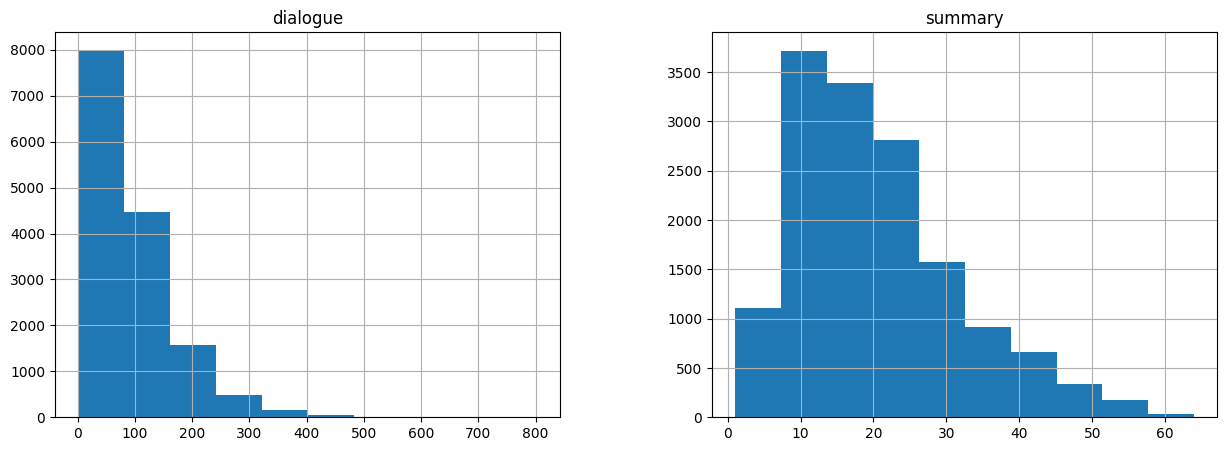

In [17]:
data.hist(figsize=(15,5))

In [18]:
def get_features(batch):
    encodings=tokenizer(batch['dialogue'],text_target=batch['summary'],max_length=1024,padding='max_length',truncation=True)
    encodings={'input_ids':encodings['input_ids'],'attention_mask':encodings['attention_mask'],'labels':encodings['labels']}
    return encodings


In [19]:
sampun_pt=dataset.map(get_features,batched=True)

Map:   0%|          | 0/819 [00:00<?, ? examples/s]

In [20]:
sampun_pt

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 14732
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 819
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 818
    })
})

In [21]:
columns=['input_ids','labels','attention_mask']

In [22]:
sampun_pt.set_format(type='torch',columns=columns)

In [23]:
from transformers import DataCollatorForSeq2Seq
data_collator=DataCollatorForSeq2Seq(tokenizer=tokenizer,model=model)

In [24]:
from transformers import TrainingArguments,Trainer

training_args=TrainingArguments(
    output_dir='results',num_train_epochs=1,warmup_steps=500,
    per_device_train_batch_size=4,per_device_eval_batch_size=4,
    weight_decay=0.01,
    logging_steps=10,
    evaluation_strategy='steps',
    eval_steps=100,
    save_steps=1e6,
    gradient_accumulation_steps=8


)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [25]:
trainer=Trainer(model=model,args=training_args,
              tokenizer=tokenizer,
              data_collator=data_collator,
              train_dataset=sampun_pt['train'],
              eval_dataset=sampun_pt['validation'])

<ipython-input-25-8a72177ee7c3>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer=Trainer(model=model,args=training_args,


In [26]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: prahaladreddy80 (prahaladreddy80-rajiv-gandhi-university-of-knowledge-tec). Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.10/dist-packages/transformers/data/data_collator.py:657: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  batch["labels"] = torch.tensor(batch["labels"], dtype=torch.int64)


Step,Training Loss,Validation Loss


OutOfMemoryError: CUDA out of memory. Tried to allocate 786.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 217.06 MiB is free. Process 184743 has 14.53 GiB memory in use. Of the allocated memory 14.31 GiB is allocated by PyTorch, and 92.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
trainer.save_model('bart_samsum_model')

pipe=pipeline('summarization',model='bart_samsum_model',tokenizer=tokenizer)
gen_kwargs={'length_penalty':0.8,'num_beams':8,'max_length':128}

custom_dialogue="""
prahald: Who are you ?
lady tomayo: I am from japan and i am tomayo. you can call me tomayo sama
prahald: And what purpose brought you here?
lady tomayo: Just passing by the valley , watching your pretty garden made me to take a closer look
prahald: I am no fool
lady tomayo: I know that well enough
"""

print(pipe(custom_dialogue,**gen_kwargs))

